In [ ]:
import random
import numpy
import pandas as pd
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse

## Introduction Genetic Algorithm

Basic Description
Genetic algorithms are inspired by Darwin's theory about evolution. Solution to a problem solved by genetic algorithms is evolved.

Algorithm is started with a set of solutions (represented by chromosomes) called population. Solutions from one population are taken and used to form a new population. This is motivated by a hope, that the new population will be better than the old one. Solutions which are selected to form new solutions (offspring) are selected according to their fitness - the more suitable they are the more chances they have to reproduce.

![](https://tutorials.retopall.com/wp-content/uploads/2019/03/GeneticAlgorithm-1-1024x374.png)

Outline of the Basic Genetic Algorithm
* **[Start]** Generate random population of n chromosomes (suitable solutions for the problem)
* **[Fitness]** Evaluate the fitness f(x) of each chromosome x in the population
    * **[New population]** Create a new population by repeating following steps until the new population is complete
    * **[Selection]** Select two parent chromosomes from a population according to their fitness (the better fitness, the bigger chance to be selected)
    * **[Crossover]** With a crossover probability cross over the parents to form a new offspring (children). If no crossover was performed, offspring is an exact copy of parents.
    * **[Mutation]** With a mutation probability mutate new offspring at each locus (position in chromosome).
    * [Accepting] Place new offspring in a new population
* **[Replace]** Use new generated population for a further run of algorithm
* **[Test]** If the end condition is satisfied, stop, and return the best solution in current population
* **[Loop]** Go to step 2

#### Define constants and support methods

In [2]:
# Probem COnstants
N_DAYS        = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125
FAMINY_SIZE   = 5000
DAYS          = list(range(N_DAYS,0,-1))


#load dataset
data        = pd.read_csv('santa.csv', index_col='family_id')
submission  = pd.read_csv('sample_submission.csv', index_col='family_id')


# Load util variables
family_size_dict  = data[['n_people']].to_dict()['n_people']
cols              = [f'choice_{i}' for i in range(10)]
choice_dict       = data[cols].T.to_dict()

# from 100 to 1
family_size_ls  = list(family_size_dict.values())
choice_dict_num = [{vv:i for i, vv in enumerate(di.values())} for di in choice_dict.values()]

# Computer penalities in a list
penalties_dict = {
  n: [
      0,
      50,
      50  + 9 * n,
      100 + 9 * n,
      200 + 9 * n,
      200 + 18 * n,
      300 + 18 * n,
      300 + 36 * n,
      400 + 36 * n,
      500 + 36 * n + 199 * n,
      500 + 36 * n + 398 * n
  ]
  for n in range(max(family_size_dict.values())+1)
} 

### Toolbox

In [3]:
# Create a Tollbox Optmizer

# The creator is a class factory that can build new classes at run-time. It will be called with first the desired name of the new class, 
# second the base class it will inherit, and in addition any subsequent arguments you want to become attributes of your class. 
# This allows us to build new and complex structures of any type of container from lists to n-ary trees.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Now we will use our custom classes to create types representing our individuals as well as our whole population.
toolbox = base.Toolbox()

### Creating the Population

The population is random. Each individual is a vector of size k, where k = total families and each value is the day chosen by family d, where d varies between 0 and 100.

In [ ]:
# Attribute generator
toolbox.register("attr_int",   random.randint, 1, 100)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, FAMINY_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

pop   = toolbox.population(n=1000)

print(pop[0])
print("len: ", len(pop))

### The Evaluation Function

The evaluation function is pretty simple in our example. We just need to count the number of ones in an individual.
The returned value must be an iterable of a length equal to the number of objectives (weights).

In [5]:
# The evaluation function is pretty simple in our example. We just need to count the number of ones in an individual.
def cost_function(prediction, family_size_ls, choice_dict, choice_dict_num, penalties_dict):
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in DAYS}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, c, c_dict, choice in zip(family_size_ls, prediction, list(choice_dict.values()), choice_dict_num):
        d = int(c)
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d not in choice:
            penalty += penalties_dict[n][-1]
        else:
            penalty += penalties_dict[n][choice[d]]

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    k = 0
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY):
            k = k + (v - MAX_OCCUPANCY)
        if (v < MIN_OCCUPANCY):
            k = k + (MIN_OCCUPANCY - v)
    #    if k > 0:
    #        penalty += 100000000 
    penalty += 100000*k

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[DAYS[0]]-125.0) / 400.0 * daily_occupancy[DAYS[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[DAYS[0]]
    for day in DAYS[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return (penalty, )

### The Genetic Operators

Within DEAP there are two ways of using operators. We can either simply call a function from the tools module or register it with its arguments in a toolbox, as we have already seen for our initialization methods. The most convenient way, however, is to register them in the toolbox, because this allows us to easily switch between the operators if desired. The toolbox method is also used when working with the algorithms module. See the One Max Problem: Short Version for an example.

Registering the genetic operators required for the evolution in our One Max problem and their default arguments in the toolbox is done as follows.

In [6]:
toolbox.register("evaluate",   cost_function, family_size_ls=family_size_ls, choice_dict=choice_dict, 
                                                 choice_dict_num=choice_dict_num, penalties_dict=penalties_dict)
toolbox.register("mate",       tools.cxUniform, indpb=0.5)
toolbox.register("select",     tools.selTournament, tournsize=10) 
toolbox.register("mutate",     tools.mutShuffleIndexes, indpb=0.5)

## Run Evolution...

In [7]:
ngen      = 100  # Gerations
npop      = 1000 # Population

hof   = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Statistics
stats.register("avg", numpy.mean, axis=0)
stats.register("std", numpy.std, axis=0)
stats.register("min", numpy.min, axis=0)
stats.register("max", numpy.max, axis=0)


# Evolution
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=npop, lambda_=npop,
                                          cxpb=0.7,   mutpb=0.3, ngen=ngen, 
                                          stats=stats, halloffame=hof)

gen	nevals	avg             	std             	min                	max             
0  	1000  	[1.40667921e+09]	[2.36971358e+10]	[10649234.96198103]	[6.36942036e+11]
1  	1000  	[11058658.16195831]	[356092.31972847]	[10649234.96198103]	[14088449.8301383]
2  	1000  	[10770342.64938748]	[71113.38179799] 	[10649234.96198103]	[11188192.70205521]
3  	1000  	[10693131.17573927]	[35255.88402661] 	[10565556.33453029]	[10822587.26594775]
4  	1000  	[10652162.07786345]	[29658.58589272] 	[10565556.33453029]	[11186907.26379286]
5  	1000  	[10617500.19466831]	[27145.50706134] 	[10533556.61341595]	[10725422.08984747]
6  	1000  	[10584631.99905635]	[17615.45771787] 	[10525767.8477847] 	[10658574.5059124] 
7  	1000  	[10563934.329252]  	[15624.71309687] 	[10525767.8477847] 	[10594939.47373946]
8  	1000  	[10543405.28086613]	[15006.09749187] 	[10498044.6079869] 	[10578696.33925849]
9  	1000  	[10526572.10065332]	[11240.4704577]  	[10498044.6079869] 	[10558646.46142235]
10 	1000  	[10511775.21467374]	[1304

In [8]:
# Best Solution
best_solution = tools.selBest(pop, 1)[0]
print("")
print("[{}] best_score: {}".format(logbook[-1]['gen'], logbook[-1]['min'][0]))


[100] best_score: 9318062.067440901


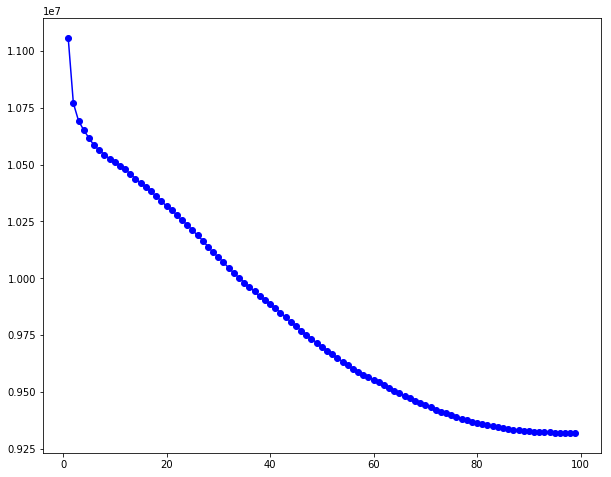

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# History AVG
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:,0][1:-1], front[:,1][1:-1], "-bo", c="b")
plt.axis("tight")
plt.show()

In [10]:
# Export Result

submission['assigned_day']=best_solution
print(submission.head())
submission.to_csv('submission_{}.csv'.format(logbook[-1]['min'][0]))  

           assigned_day
family_id              
0                    83
1                    67
2                    52
3                    17
4                    54


## Conclusion

It has been shown that the DEAP library can be used to optimize the proposed problem. The optimization speed depends on the parameterization of each step of the genetic algorithm.
